# Training the model to predict a stock price increase in the next 10 days
https://www.analyticsvidhya.com/blog/2021/08/complete-guide-on-how-to-use-lightgbm-in-python/

In [348]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score
from sklearn.model_selection import RandomizedSearchCV
import pickle
import time

import talib
from talib.abstract import *

import warnings
warnings.filterwarnings('ignore')

In [340]:
# Create the target variable

# pick a number of days that can be split evenly 80/20 and add 10
days_of_data = 510
data = yf.download(tickers='HOG', period=f'{days_of_data}d', progress=False)

# Code the target variable 1 for a day if the price goes above
# that day's price * 1.05 (5% increase) any day in the next 10 days.
data['target'] = 0
for d in range(0, days_of_data - 10):
    close_day_zero = data.iloc[d][3]

    # look at the next 10 days
    for i in range (d+1, d+10):
        # get closing price on that day
        close_day_i = data.iloc[i][3]
        # if closing price on that day > closing price * 1.05 on initial day,
        # then set target = 1 for the initial day
        if close_day_i > close_day_zero * 1.03:
            data.iloc[d:d+1, 6] = 1
        
# truncate so we just have the first set of rows, since we can't code the last 10
data = data.head(days_of_data - 10)

In [341]:
# check distribution of 0 vs. 1
data['target'].value_counts()

1    283
0    217
Name: target, dtype: int64

In [342]:
###############################################
# attach additional features to each row here #
###############################################

# set up running_df
running_df = pd.DataFrame([], columns=['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'])
running_df.index = running_df['Date']
running_df.drop(columns=['Date'], inplace=True)

# add columns
running_df['sma_10'] = np.NaN
running_df['sma_20'] = np.NaN
running_df['sma_30'] = np.NaN
running_df['macd'] = np.NaN
running_df['macdsignal'] = np.NaN
running_df['macdhist'] = np.NaN
running_df['rsi'] = np.NaN

for i in range(len(data)):
    running_df = running_df.append(data.iloc[i:i+1, 0:6])

    if len(running_df) > 10:
        running_df.iloc[-1:-2:-1, 6] = SMA(running_df.iloc[-1:-11:-1]['Close'].values, timeperiod=10)[-1]

    if len(running_df) > 20:
        running_df.iloc[-1:-2:-1, 7] = SMA(running_df.iloc[-1:-21:-1]['Close'].values, timeperiod=20)[-1]

    if len(running_df) > 30:
        running_df.iloc[-1:-2:-1, 8] = SMA(running_df.iloc[-1:-31:-1]['Close'].values, timeperiod=30)[-1]

    if len(running_df) > 33:
        macd, macdsignal, macdhist = MACD(running_df['Close'].values, fastperiod=12, slowperiod=26, signalperiod=9)
        running_df.iloc[-1:-2:-1, 9] = macd[-1]
        running_df.iloc[-1:-2:-1, 10] = macdsignal[-1]
        running_df.iloc[-1:-2:-1, 11] = macdhist[-1]
    
    if len(running_df) > 14:
        real = RSI(running_df['Close'].values, timeperiod=14)
        running_df.iloc[-1:-2:-1, 12] = real[-1]

running_df

,Open,High,Low,Close,Adj Close,Volume,sma_10,sma_20,sma_30,macd,macdsignal,macdhist,rsi
Date,,,,,,,,,,,,,
2020-01-16,35.639999,36.090000,35.619999,35.759998,34.683784,867600,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-17,35.869999,36.169998,35.389999,35.720001,34.644985,1177000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-21,35.540001,35.709999,35.020000,35.169998,34.111538,1116500,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-22,35.310001,35.349998,34.910000,35.169998,34.111538,1401700,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-23,34.919998,35.349998,34.520000,35.250000,34.189129,1731100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-03,37.880001,38.139999,37.560001,37.700001,37.700001,1148800,36.604001,37.0760,37.282667,-0.056370,-0.230009,0.173639,53.985284
2022-01-04,38.080002,39.189999,38.080002,39.029999,39.029999,1457800,36.999001,37.1435,37.337334,0.101312,-0.163745,0.265057,61.668305
2022-01-05,39.000000,39.939999,38.320000,38.439999,38.439999,1842200,37.318000,37.1485,37.311000,0.176631,-0.095670,0.272301,57.112625


In [343]:
# check column types
running_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 500 entries, 2020-01-16 to 2022-01-07
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Open        500 non-null    float64
 1   High        500 non-null    float64
 2   Low         500 non-null    float64
 3   Close       500 non-null    float64
 4   Adj Close   500 non-null    float64
 5   Volume      500 non-null    object 
 6   sma_10      490 non-null    float64
 7   sma_20      480 non-null    float64
 8   sma_30      470 non-null    float64
 9   macd        467 non-null    float64
 10  macdsignal  467 non-null    float64
 11  macdhist    467 non-null    float64
 12  rsi         486 non-null    float64
dtypes: float64(12), object(1)
memory usage: 54.7+ KB


In [344]:
# convert Volume to numeric because it changed to object for some reason
running_df['Volume'] = pd.to_numeric(running_df.Volume)

In [345]:
running_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 500 entries, 2020-01-16 to 2022-01-07
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Open        500 non-null    float64
 1   High        500 non-null    float64
 2   Low         500 non-null    float64
 3   Close       500 non-null    float64
 4   Adj Close   500 non-null    float64
 5   Volume      500 non-null    int64  
 6   sma_10      490 non-null    float64
 7   sma_20      480 non-null    float64
 8   sma_30      470 non-null    float64
 9   macd        467 non-null    float64
 10  macdsignal  467 non-null    float64
 11  macdhist    467 non-null    float64
 12  rsi         486 non-null    float64
dtypes: float64(12), int64(1)
memory usage: 54.7 KB


In [346]:
# 80/20 test/train split
train_days = int((days_of_data - 10) * .8)
test_days = int(train_days * .2)

x_train = running_df.head(train_days)
y_train = data['target'].head(train_days)

x_test = running_df.tail(test_days)
y_test = data['target'].tail(test_days)

In [349]:
lgbm_rand_gs = lgb.LGBMClassifier()

#Define the parameters
parameters = {'num_leaves':[20,40,60,80,100], 'min_child_samples':[5,10,15],'max_depth':[-1,5,10,20],
             'learning_rate':[0.05,0.1,0.2],'reg_alpha':[0,0.01,0.03]}
#Define the scoring
clf = RandomizedSearchCV(lgbm_rand_gs,parameters,scoring='recall',n_iter=100)
clf.fit(X=x_train, y=y_train)
print(clf.best_params_)
predicted=clf.predict(x_test)
print('Accuracy score for test set:', accuracy_score(y_test, predicted))
print('Recall score for test set:', recall_score(y_test, predicted))

{'reg_alpha': 0.03, 'num_leaves': 100, 'min_child_samples': 15, 'max_depth': 10, 'learning_rate': 0.05}
Accuracy score for test set: 0.4875
Recall score for test set: 1.0


In [363]:
# train the model
model = lgb.LGBMClassifier(reg_alpha=0.03, num_leaves=100, min_child_samples=15, max_depth=10, learning_rate=0.05, random_state=42)

model.fit(x_train,y_train,eval_set=[(x_test,y_test),(x_train,y_train)],
          verbose=20,eval_metric='logloss')

[20]	training's binary_logloss: 0.392052	valid_0's binary_logloss: 0.937816
[40]	training's binary_logloss: 0.261185	valid_0's binary_logloss: 1.06939
[60]	training's binary_logloss: 0.177511	valid_0's binary_logloss: 1.26455
[80]	training's binary_logloss: 0.125296	valid_0's binary_logloss: 1.36118
[100]	training's binary_logloss: 0.0902359	valid_0's binary_logloss: 1.40435


LGBMClassifier(learning_rate=0.05, max_depth=10, min_child_samples=15,
               num_leaves=100, random_state=42, reg_alpha=0.03)

In [364]:
# evaluate model accuracy
print('Training accuracy {:.4f}'.format(model.score(x_train,y_train)))
print('Testing accuracy {:.4f}'.format(model.score(x_test,y_test)))

Training accuracy 1.0000
Testing accuracy 0.4875


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

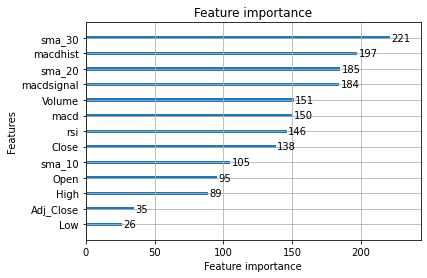

In [365]:
lgb.plot_importance(model)

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='binary_logloss'>

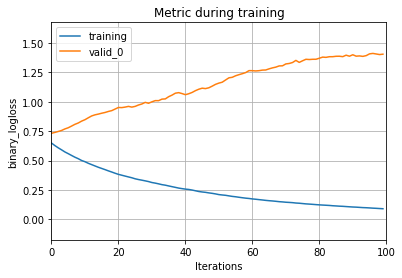

In [366]:
lgb.plot_metric(model)

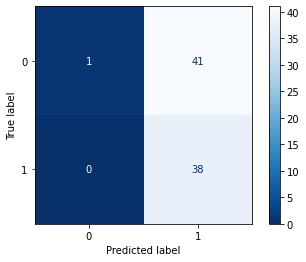

In [367]:
metrics.plot_confusion_matrix(model,x_test,y_test,cmap='Blues_r')

In [368]:
print(metrics.classification_report(y_test,model.predict(x_test)))

              precision    recall  f1-score   support

           0       1.00      0.02      0.05        42
           1       0.48      1.00      0.65        38

    accuracy                           0.49        80
   macro avg       0.74      0.51      0.35        80
weighted avg       0.75      0.49      0.33        80



In [369]:
pkl_filename = 'lgbm_model.pkl'

with open(pkl_filename, 'wb') as file:  
    pickle.dump(model, file)